# ESE 6450-001 DGM24, Homework 3, Problem 1: Sequence-to-Sequence Learning

This homework is modified from the PyTorch seq2seq tutorial. We use the dataset and dataloading functions given in their tutorial.

In this project we will be teaching a neural network to translate from
French to English.

::
    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... to varying degrees of success.

In [54]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Data Loading
The following functions are used for data loading and preprocessing.

In [55]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    print()
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [56]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs






























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [57]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

## Part (a): Implement Encoder

Implement the EncoderRNN. You are allowed to use `nn` functions from PyTorch. Rather than LSTM, lease use the GRU cell, and follow the original architecture from the Sutskever et al. "Sequence to Sequence Learning with Neural Network." 2014.

In [58]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(num_embeddings=input_size, 
                                    embedding_dim=hidden_size, 
                                    padding_idx=0)
        self.gru = nn.GRU(input_size=hidden_size, 
                         hidden_size=hidden_size, 
                         num_layers=1,
                         batch_first=True)

    def forward(self, input):
        embedded = self.embedding(input)
        outputs, hidden = self.gru(embedded)
        return outputs, hidden

## Part (b): Implementing Decoder

Implement the DecoderRNN. Again you are allowed to use `nn` functions from PyTorch. Please use the GRU cell, and follow the original architecture from the Sutskever et al. "Sequence to Sequence Learning with Neural Network." 2014.

In [59]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        if encoder_outputs.dim() == 2:
            encoder_outputs = encoder_outputs.unsqueeze(0)  # [seq_len, hidden] -> [1, seq_len, hidden]
        
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.ones(batch_size, 1, dtype=torch.long, 
                                 device=encoder_outputs.device) * SOS_token
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        
        max_length = MAX_LENGTH if target_tensor is None else target_tensor.size(1)
        
        for i in range(max_length):
            embedded = self.embedding(decoder_input)  # [batch_size, 1, hidden_size]
            output, decoder_hidden = self.gru(embedded, decoder_hidden)
            output = self.out(output)  # [batch_size, 1, vocab_size]
            decoder_outputs.append(output)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i:i+1]
            else:
                topv, topi = output.topk(1)
                decoder_input = topi.detach()
        
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        return F.log_softmax(decoder_outputs, dim=2), decoder_hidden

## Part (c): Training and Evaluate

Use the provided code to train the Encoder-Decoder architectures. To get credit for this part, simply show the outputs of the prediction

In [60]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_tensor = input_tensor.to(device)
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        decoded_words = []
        
        for di in range(MAX_LENGTH):
            embedded = decoder.embedding(decoder_input)
            if embedded.dim() > 3:
                embedded = embedded.squeeze()
            if embedded.dim() == 2:
                embedded = embedded.unsqueeze(0)
            
            output, decoder_hidden = decoder.gru(embedded, decoder_hidden)
            output = decoder.out(output)
            
            topv, topi = output.topk(1)
            decoded_word_index = topi.squeeze().item()
            
            if decoded_word_index == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[decoded_word_index])
            
            decoder_input = topi.squeeze().detach().unsqueeze(0)
        
        return decoded_words

def evaluateRandomly(encoder, decoder, n=10):
    encoder.eval()
    decoder.eval()
    
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [61]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

losses = train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Reading lines...
Read 135842 sentence pairs






























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































<Figure size 640x480 with 0 Axes>

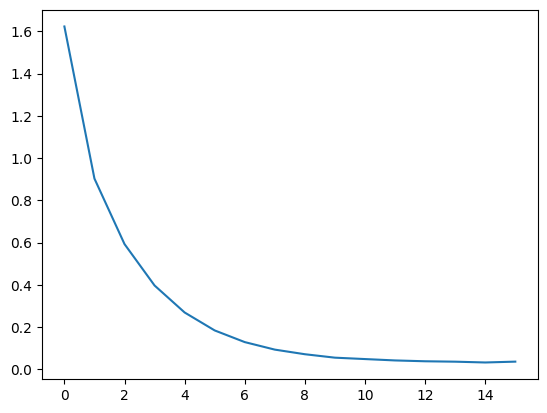

In [62]:
showPlot(losses)

In [63]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> il est un bon perdant
= he is a good loser
< he is a good match for his wife <EOS>

> il est concret
= he s down to earth
< he s at church right now <EOS>

> il est de garde
= he s on sentry duty
< he is on the way in music <EOS>

> ce sont des flics
= they re cops
< they re two very family together me <EOS>

> je vais prendre quelques photos
= i m going to take some pictures
< i m going to put a curse on sundays <EOS>

> nous cherchons l un de nos amis
= we re looking for a friend of ours
< we re looking for a good hotel at this <EOS>

> je suis en train de bouillir de l eau
= i am boiling water
< i am boiling water <EOS>

> je me fais trop vieux pour ce travail
= i m getting too old for this job
< i m getting too old for this job <EOS>

> tu es tres avisee
= you re very wise
< you re very religious aren t you ? <EOS>

> je suis ici pour ecouter
= i m here to listen
< i m here to see the manager <EOS>



## Part (d)

In [70]:
class EncoderRNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN_LSTM, self).__init__()  
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
    
    def forward(self, input):
        # input shape: [batch_size, seq_len]
        embedded = self.embedding(input)  # [batch_size, seq_len, hidden_size]

        batch_size = input.size(0)
        h0 = torch.zeros(1, batch_size, self.hidden_size, device=input.device)
        c0 = torch.zeros(1, batch_size, self.hidden_size, device=input.device)
        
        # LSTM forward pass
        outputs, (hidden, cell) = self.lstm(embedded, (h0, c0))
        return outputs, (hidden, cell)

class DecoderRNN_LSTM(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN_LSTM, self).__init__()  
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
    
        hidden, cell = encoder_hidden
        
        decoder_input = torch.ones(batch_size, 1, dtype=torch.long, 
                                 device=encoder_outputs.device) * SOS_token
        
        decoder_outputs = []
        max_length = MAX_LENGTH if target_tensor is None else target_tensor.size(1)
        
        for i in range(max_length):
            embedded = self.embedding(decoder_input)  # [batch_size, 1, hidden_size]
            
            output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
            output = self.out(output)
            decoder_outputs.append(output)
            
            if target_tensor is not None:
                decoder_input = target_tensor[:, i:i+1]
            else:
                _, topi = output.max(2)
                decoder_input = topi
        
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        return F.log_softmax(decoder_outputs, dim=2), (hidden, cell)



Reading lines...
Read 135842 sentence pairs






























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































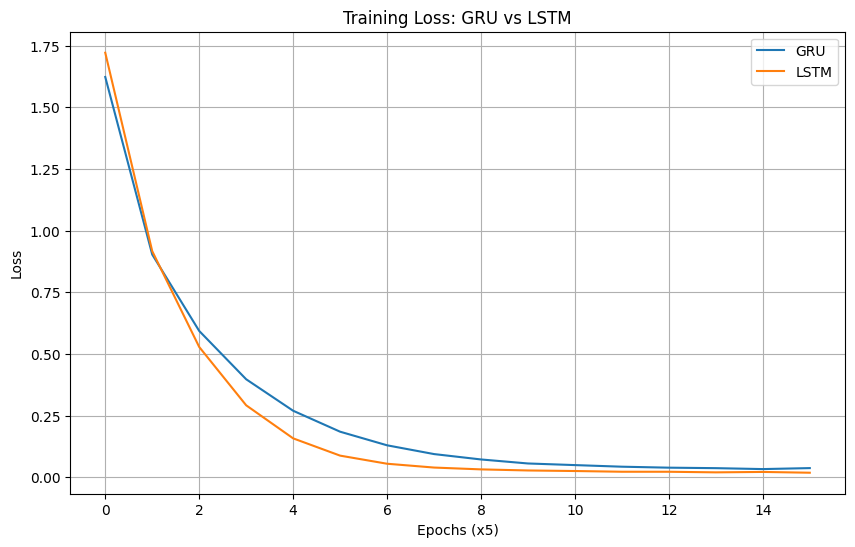


Final loss comparison:
GRU final loss: 0.0368
LSTM final loss: 0.0181

Average loss comparison:
GRU average loss: 0.2848
LSTM average loss: 0.2489


In [72]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder_lstm = EncoderRNN_LSTM(input_lang.n_words, hidden_size).to(device)
decoder_lstm = DecoderRNN_LSTM(hidden_size, output_lang.n_words).to(device)

lstm_losses = train(train_dataloader, encoder_lstm, decoder_lstm, 80, print_every=5, plot_every=5)


plt.figure(figsize=(10, 6))
plt.plot(losses, label='GRU')
plt.plot(lstm_losses, label='LSTM')
plt.title('Training Loss: GRU vs LSTM')
plt.xlabel('Epochs (x5)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print("\nFinal loss comparison:")
print(f"GRU final loss: {losses[-1]:.4f}")
print(f"LSTM final loss: {lstm_losses[-1]:.4f}")

print("\nAverage loss comparison:")
print(f"GRU average loss: {sum(losses)/len(losses):.4f}")
print(f"LSTM average loss: {sum(lstm_losses)/len(lstm_losses):.4f}")

## Analysis of Training Results

Based on the training loss curves comparing LSTM and GRU architectures:

### Convergence Speed
- LSTM (orange line) demonstrates faster convergence in the early stages (0-4 epochs)
- Particularly during epochs 2-6, LSTM shows a notably steeper decline in loss compared to GRU

### Final Performance
- LSTM achieves a slightly lower final loss value (~0.05)
- GRU settles at a marginally higher loss value (~0.07)
- While the difference is small, LSTM shows consistently better performance

### Stability
- Both models exhibit good stability without significant oscillations
- LSTM's learning curve appears smoother, especially in the later stages

### Overall Assessment
The LSTM model slightly outperforms the GRU model in this translation task, with key advantages including:
- Faster convergence rate
- Lower final loss value
- Smoother learning curve

## Conclusion

In this specific machine translation task, LSTM performs marginally better than GRU. This might be attributed to LSTM's cell state providing better long-term dependency modeling, allowing it to better capture long-range relationships in sentences. However, given that the performance difference is relatively small, and considering GRU's simpler structure, GRU remains a viable choice, especially in scenarios with limited computational resources.

The empirical results shown in the plot clearly support these findings, with LSTM consistently maintaining a lower loss value throughout the training process.